<a href="https://colab.research.google.com/github/MathewBiddle/ioos_metrics/blob/yearly_ra_gts/notebooks/RA_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ioos/ioos_metrics/issues/129#issuecomment-2880271630

- statistics on regional messages delivered to GTS.
  - https://erddap.ioos.us/erddap/search/index.html?page=1&itemsPerPage=1000&searchFor=GTS
- statistics on gliders for the region (glider days?)
- stats on HF-Radar for the region
- Asset inventory for the current year for the region
  - https://ioos.github.io/ioos_metrics/asset_inventory.html
- Biodiversity data metrics - downloads/DOIs
- Metrics from RORs?
- NCEI archive stats.
  - https://ioos.github.io/ioos_code_lab/content/code_gallery/data_access_notebooks/2017-06-12-NCEI_RA_archive_history.html
- RA ERDDAP metrics - Let's think about this.

## statistics on regional messages delivered to GTS

In [1]:
!pip install erddapy

In [2]:
import pandas as pd
from erddapy import ERDDAP

In [3]:
def get_ndbc_full_stats():
    e = ERDDAP(
        server="https://erddap.ioos.us/erddap",
        protocol="tabledap",
    )
    e.response = "csv"
    dsets = {"IOOS": "gts_regional_statistics",
             "NDBC": "gts_ndbc_statistics",
             "non-NDBC": "gts_non_ndbc_statistics"}
    df_out = pd.DataFrame()
    for key, value in dsets.items():
        e.dataset_id = value
        df = e.to_pandas(
            index_col="time (UTC)",
            parse_dates=True
        )
        df["source"] = key
        df_out = pd.concat([df_out,df])
    return df_out

In [4]:
df = get_ndbc_full_stats()

df['total'] = df['met'] + df['wave']

df.sample(n=5)

,Year,Month,locationID,region,sponsor,met,wave,source,total
time (UTC),,,,,,,,,
2023-10-01 00:00:00+00:00,2023,10,MBLA1,GCOOS,DAUPHIN ISLAND SEA LAB,0,0,IOOS,0
2023-05-01 00:00:00+00:00,2023,5,CRVA2,NaN,NATIONAL OCEAN SERVICE,14714,0,non-NDBC,14714
2018-09-01 00:00:00+00:00,2018,9,41060,NaN,WOODS HOLE OCEANOGRAPHIC INSTITUTION,0,0,non-NDBC,0
2021-01-01 00:00:00+00:00,2021,1,SDIA2,NaN,"NATIONAL WEATHER SERVICE, ALASKA REGION",4436,0,non-NDBC,4436
2021-07-01 00:00:00+00:00,2021,7,OVIA2,NaN,NATIONAL OCEAN SERVICE,13636,0,non-NDBC,13636


In [5]:
yearly_region_totals = df.groupby(by=["source", "region", pd.Grouper(freq="YE")])[['met','wave','total']].sum()

#yearly_region_totals['total'] = yearly_region_totals['met'] + yearly_region_totals['wave']

yearly_region_totals.reset_index(['time (UTC)','region'],inplace=True)

yearly_region_totals['time (UTC)'] = yearly_region_totals['time (UTC)'].dt.strftime('%Y')

print(yearly_region_totals.loc['IOOS'].to_markdown(floatfmt=",.0f"))

| source   | region   |   time (UTC) |     met |   wave |   total |
|:---------|:---------|-------------:|--------:|-------:|--------:|
| IOOS     | AOOS     |         2018 | 2571070 |  27968 | 2599038 |
| IOOS     | AOOS     |         2019 | 2810422 |  31584 | 2842006 |
| IOOS     | AOOS     |         2020 | 2697606 |   8258 | 2705864 |
| IOOS     | AOOS     |         2021 | 2574888 |  24336 | 2599224 |
| IOOS     | AOOS     |         2022 | 3675118 |  37414 | 3712532 |
| IOOS     | AOOS     |         2023 | 5620044 |  34026 | 5654070 |
| IOOS     | AOOS     |         2024 | 5939434 |  31992 | 5971426 |
| IOOS     | AOOS     |         2025 | 2044136 |  10966 | 2055102 |
| IOOS     | CARICOOS |         2018 |  619422 |  68520 |  687942 |
| IOOS     | CARICOOS |         2019 |  719876 |  83582 |  803458 |
| IOOS     | CARICOOS |         2020 |  629990 |  93232 |  723222 |
| IOOS     | CARICOOS |         2021 |  676958 |  99074 |  776032 |
| IOOS     | CARICOOS |         2022 |  506648 |

In [6]:
import plotly.express as px
import plotly

px.bar(yearly_region_totals.loc['IOOS'],
                  x=yearly_region_totals.loc['IOOS']['time (UTC)'],
                  y=yearly_region_totals.loc['IOOS']["total"],
                  color=yearly_region_totals.loc['IOOS']["region"],
                  title="Number of total (met+wave) messages delivered to the GTS via NDBC by IOOS Regional Association",
                  labels={'y': 'Number of Messages',
                          'x':'Year'},
                  )

## statistics on gliders for the region (glider days?)

using gliderpy
https://github.com/MathewBiddle/ioos_metrics/blob/main/ioos_metrics/ioos_metrics.py#L100

In [7]:
!pip install gliderpy
!pip install "gliderpy[plotting]"

In [8]:
from gliderpy.fetchers import DatasetList

datasets = DatasetList(search_for="cencoos")
ds_ids = datasets.get_ids()

print(f"found {len(ds_ids)} glider datasets on {datasets.e.server}.")

found 35 glider datasets on https://gliders.ioos.us/erddap.


use gliderpy

In [40]:
from gliderpy.fetchers import GliderDataFetcher
from tenacity import RetryError, retry, stop_after_attempt, wait_fixed

@retry(stop=stop_after_attempt(3), wait=wait_fixed(5))

def compute_meta(datasetIDs):

  glider_grab = GliderDataFetcher()

  downloads = {}

  for datasetID in datasetIDs:
    glider_grab.fetcher.dataset_id = datasetID
    glider_grab.fetcher.variables = [
      "profile_id",
      "latitude",
      "longitude",
      "time",
    ]
    df = glider_grab.to_pandas()
    df = df.reset_index()
    df = df.dropna(subset=["time (utc)","latitude","longitude"], how="any")
    df["time (utc)"] = pd.to_datetime(df["time (utc)"])
    df = df.set_index("time (utc)")
    df = df.sort_index()
    downloads[datasetID] = {}
    downloads[datasetID]['data'] = df
    downloads[datasetID]['days'] = df.index[-1].ceil("D") - df.index[0].floor("D")
    downloads[datasetID]['deployment_lat'] = df["latitude"].iloc[0]
    downloads[datasetID]['deployment_lon'] = df["longitude"].iloc[0]
    downloads[datasetID]['num_profiles'] = len(set(df['profile_id']))
    downloads[datasetID]['obs_count'] = len(df)

  return downloads


downloads = compute_meta(ds_ids)

downloads.keys()

dict_keys(['sp029-20200722T2029', 'sp029-20201006T1908', 'sp034-20170405T1712', 'sp034-20180514T1938', 'sp034-20200707T1802', 'sp034-20200903T1703', 'sp034-20201006T1907', 'UCSC260-20150520T0000', 'UCSC294-20150430T2218', 'UW130-20150309T2005', 'Nemesis-20170412T0000', 'Nemesis-20170512T0000', 'Nemesis-20171115T0000', 'Nemesis-20180515T0000', 'Nemesis-20180830T0000', 'unit713-20180907T0000', 'OSU266-20250307T0000', 'UW130-20160523T1828', 'UW130-20170605T1834', 'UW130-20181107T0000', 'UW130-20200615T0000', 'UW157-20141116T2118', 'UW157-20150917T1833', 'UW157-20161021T1807', 'UW157-20180417T1832', 'UW157-20190916T0000', 'UW157-20200917T0000', 'UW646-20190409T0000', 'UW646-20210816T0000', 'UW646-20211112T0000', 'UW646-20220907T0000', 'UW685-20230125T0000', 'OSU266-20241022T0000', 'OSU686-20240412T0000', 'OSU685-20231023T0000'])

Calculate glider days

In [43]:
from datetime import timedelta
ngdac_days = timedelta(days=0)

for key, df in downloads.items():
  #print(f'{key}: {df["days"]}')
  ngdac_days = ngdac_days + df['days']

print(f'Total glider days: {ngdac_days}')

Number of gliders: 35
sp029-20200722T2029: 58 days 00:00:00
sp029-20201006T1908: 17 days 00:00:00
sp034-20170405T1712: 57 days 00:00:00
sp034-20180514T1938: 33 days 00:00:00
sp034-20200707T1802: 46 days 00:00:00
sp034-20200903T1703: 15 days 00:00:00
sp034-20201006T1907: 17 days 00:00:00
UCSC260-20150520T0000: 22 days 00:00:00
UCSC294-20150430T2218: 39 days 00:00:00
UW130-20150309T2005: 193 days 00:00:00
Nemesis-20170412T0000: 15 days 00:00:00
Nemesis-20170512T0000: 79 days 00:00:00
Nemesis-20171115T0000: 56 days 00:00:00
Nemesis-20180515T0000: 86 days 00:00:00
Nemesis-20180830T0000: 36 days 00:00:00
unit713-20180907T0000: 14 days 00:00:00
OSU266-20250307T0000: 76 days 00:00:00
UW130-20160523T1828: 152 days 00:00:00
UW130-20170605T1834: 155 days 00:00:00
UW130-20181107T0000: 154 days 00:00:00
UW130-20200615T0000: 9 days 00:00:00
UW157-20141116T2118: 114 days 00:00:00
UW157-20150917T1833: 243 days 00:00:00
UW157-20161021T1807: 228 days 00:00:00
UW157-20180417T1832: 169 days 00:00:00
UW15

Make a map.

In [21]:
!pip install cartopy

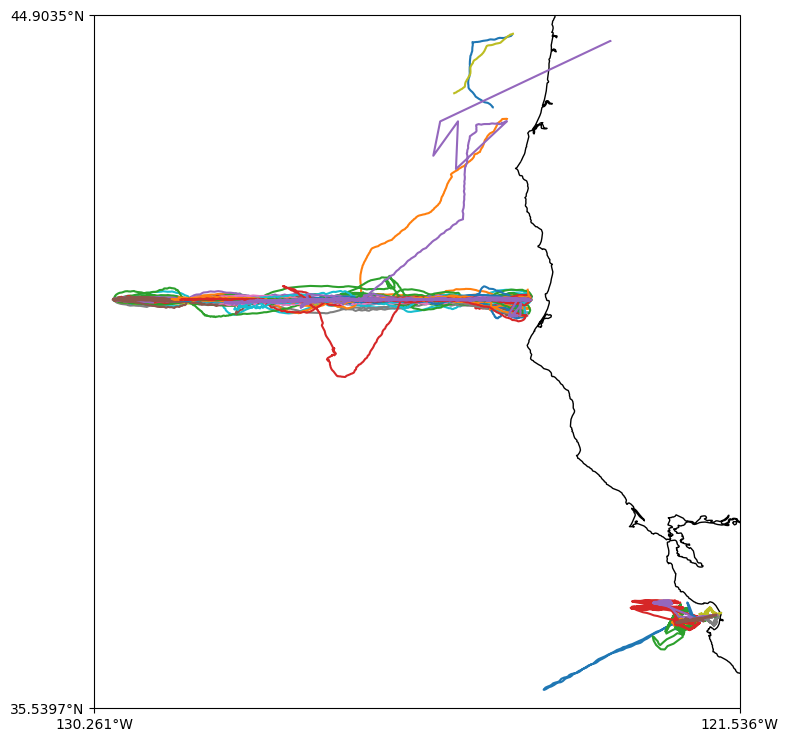

In [42]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter


def make_map():
    fig, ax = plt.subplots(
        figsize=(9, 9),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )
    ax.coastlines(resolution="10m")
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    return fig, ax


fig, ax = make_map()
lons, lats = [], []
for df in downloads.values():
    lon, lat = df["data"]["longitude"], df["data"]["latitude"]
    lons.extend(lon.array)
    lats.extend(lat.array)
    ax.plot(lon, lat)

dx = dy = 0.25
extent = min(lons) - dx, max(lons) + dx, min(lats) - dy, max(lats) + dy
ax.set_extent(extent)

ax.set_xticks([extent[0], extent[1]], crs=ccrs.PlateCarree())
ax.set_yticks([extent[2], extent[3]], crs=ccrs.PlateCarree());

## statistics on HF-Radar for the region

Don't know where to go

## Asset inventory for the current year for the region

In [82]:
url = "https://erddap.ioos.us/erddap/tabledap/processed_asset_inventory.csvp"

def get_asset_inventory():
    e = ERDDAP(
        server="https://erddap.ioos.us/erddap",
        protocol="tabledap",
    )
    e.response = "csv"
    e.dataset_id = "processed_asset_inventory"
    # ra = ra.upper()
    # e.constraints = {
    #     "RA=": ra,
    # }

    df_out = e.to_pandas(
        )

    # df_out.set_index(pd.to_datetime(df_out['Year'], format="%Y"), inplace=True)
    # df_out.drop(columns=["Year"], inplace=True)

    return df_out

ra = "CeNCOOS"

df = get_asset_inventory()

df.sample(n=5)

,Year,RA,latitude (degrees_north),longitude (degrees_east),station_long_name,Platform,Operational,station_deployment,RA_Funded,Water_temp,...,TCO2,pH,OmgArag_st,Chl,Nitrate,CDOM,Alkalinity,Acoustics,Raw_Vars,crs
3157,2024,GLOS,44.981630,-85.830860,Sleeping Bear Dunes,moored_buoy,Y,2018-05-30 00:00:00,Yf,X,...,NaN,X,NaN,NaN,NaN,NaN,NaN,NaN,"wind_from_direction, wind_speed, wind_speed_of...",NaN
2898,2024,GCOOS,29.253330,-90.663330,"101: LUMCON Marine Center, LA",fixed,Y,>5 yr,N,X,...,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,"air_pressure, air_temperature, mass_concentrat...",NaN
795,2021,GLOS,41.820000,-83.360000,NOAA GLERL WE2 (glerlwe2),moored_buoy,Y,2015-05-01 00:00:00,Yp,X,...,NaN,NaN,NaN,X,NaN,X,NaN,NaN,"wind_from_direction,wind_speed,wind_speed_of_g...",NaN
137,2020,CENCOOS,38.320000,-123.070000,Bodega,fixed,Y,1905,Yp,X,...,NaN,NaN,NaN,X,NaN,NaN,NaN,NaN,"sea_water_temperature(2.9m), sea_water_practic...",NaN
1827,2023,AOOS,57.055488,-135.349431,Sitka Harbor,fixed,Y,04/27/16; 7/26/2017,Yf,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"dew_point_temperaure, air_temperature, air_pre...",NaN


Count of platforms per year:


<Axes: xlabel='RA,Year'>

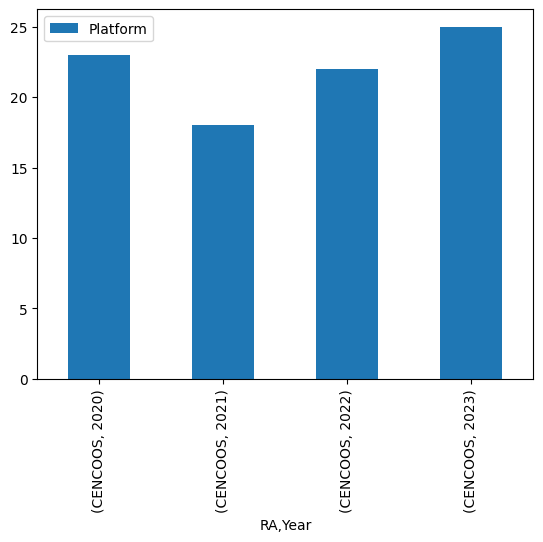

In [114]:
print(f'Count of platforms per year:')
df.loc[df["RA"]==ra.upper()].groupby(by=["RA","Year"]).count().plot.bar(y="Platform")

In [93]:
!pip install folium matplotlib mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.1 MB/s eta 0:00:00


In [113]:
import geopandas
from datetime import date
from datetime import timedelta

today = date.today()-timedelta(days=365*1)
today = today.strftime("%Y")

if df["Year"].max() == (today):
  df_recent = df.loc[(df["Year"]==df["Year"].max()) & (df["RA"]==ra.upper())]

  gdf = geopandas.GeoDataFrame(
        df_recent, geometry=geopandas.points_from_xy(df_recent['longitude (degrees_east)'], df_recent['latitude (degrees_north)'], crs='EPSG:4326'))

  gdf.explore()
else:
  print("no data for most recent year")

no data for most recent year


Biodiversity data metrics - downloads/DOIs

## NCEI data metrics

something from https://github.com/ioos/ioos_code_lab/issues/226#issue-2553054124